In [9]:
%reset -f

In [10]:
import plotting
from pyseis.wave_equations import elastic_isotropic, acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

In [11]:
import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/ForwardModeling/wrk/


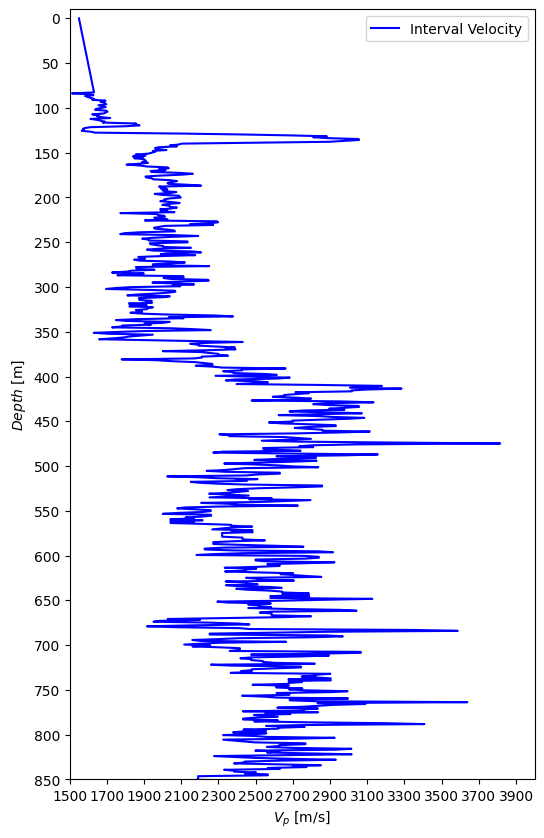

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the log data from the CSV file in the current directory
file_path = 'Curtin_DAS_VSP_Sonic_modified.csv'  # CSV file in the current folder
df = pd.read_csv(file_path)

# Extract depth and interval velocity from the loaded data
depths = df['Depth (DAS)'].values
interval_velocities = df['interval velocity'].values

# Plot settings
depmin, depmax, depstep = -10, 850, 50
vmin, vmax, vstep = 1500, 4000, 200

# Plotting the data
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1,1,1)

# Plot interval velocities (original only, no interpolation)
ax1.plot(interval_velocities, depths, lw=1.5, color='blue', label='Interval Velocity')

# Label and format the plot
ax1.set_xlabel('$V_p$ [m/s]')
ax1.set_ylabel('$Depth$ [m]')
ax1.set_xlim(vmin, vmax)
ax1.set_ylim(depmax, depmin)  # depth increases downward
ax1.set_xticks(np.arange(vmin, vmax, vstep))
ax1.set_yticks(np.arange(depmax, depmin, -depstep))
ax1.legend()

plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


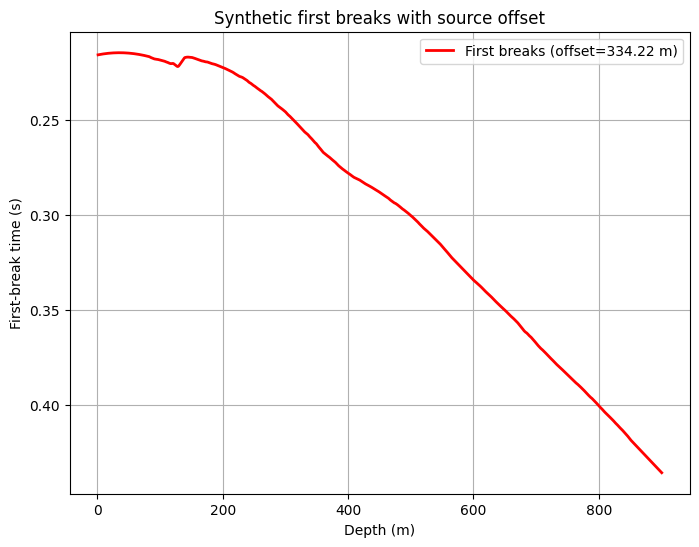

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# depth (m) and velocity (m/s) from your sonic log
depth = depths
vel = interval_velocities

# cumulative one-way vertical time
dz = np.diff(depth)
v_mid = (vel[:-1] + vel[1:]) / 2.0
t_vert = np.concatenate([[0], np.cumsum(dz / v_mid)])

# average velocity to each depth
v_avg = depth / (t_vert + 1e-9)   # avoid div by zero at surface

# --- source geometry ---
x_src = 334.22   # horizontal offset in m (example)
z_src = 0.0     # source depth in m (0 = surface)

# compute first breaks
first_breaks_time = []
for zr, vav in zip(depth, v_avg):
    L = np.sqrt(x_src**2 + (zr - z_src)**2)   # straight-line path
    t = L / vav
    first_breaks_time.append(t)

first_breaks_time = np.array(first_breaks_time)

# convert to sample indices
dt = 0.001
first_breaks_idx = (first_breaks_time / dt).astype(int)

# --- plot ---
plt.figure(figsize=(8,6))
plt.plot(depth, first_breaks_time, 'r-', lw=2, label=f"First breaks (offset={x_src} m)")
plt.gca().invert_yaxis()
plt.xlabel("Depth (m)")
plt.ylabel("First-break time (s)")
plt.title("Synthetic first breaks with source offset")
plt.grid(True); plt.legend()
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


Trace index range (after shift): 0 882


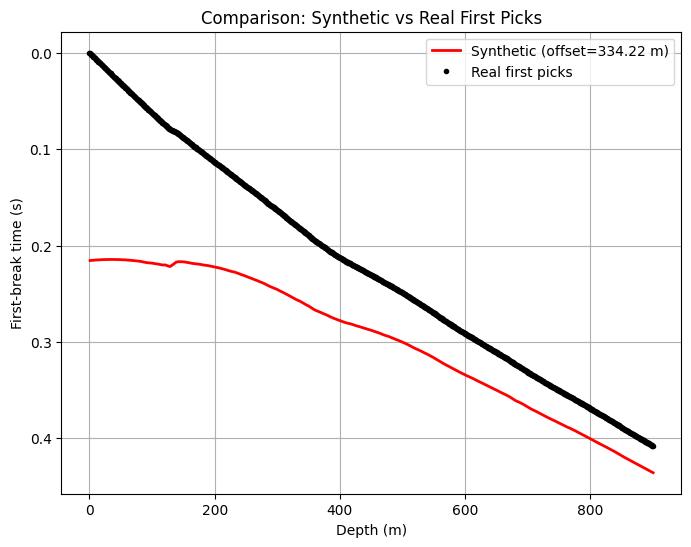

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- load sonic log ---
depth = depths                   # from your previous DataFrame (m)
vel = interval_velocities        # (m/s)

# --- compute synthetic first breaks from sonic log ---
dz = np.diff(depth)
v_mid = (vel[:-1] + vel[1:]) / 2.0
t_vert = np.concatenate([[0], np.cumsum(dz / v_mid)])
v_avg = depth / (t_vert + 1e-9)

x_src = 334.22   # horizontal offset in m (example)
z_src = 0.0     # source depth in m

first_breaks_time = []
for zr, vav in zip(depth, v_avg):
    L = np.sqrt(x_src**2 + (zr - z_src)**2)
    t = L / vav
    first_breaks_time.append(t)

first_breaks_time = np.array(first_breaks_time)

# --- load real first pick data ---
real_fp = pd.read_csv("real_first_picks_run4.csv", header=None, names=["trace", "time"])
real_trace = real_fp["trace"].values.astype(int) - 1   # shift to 0-based
real_time  = real_fp["time"].values

# --- safety check ---
print("Trace index range (after shift):", real_trace.min(), real_trace.max())  # should be 0…882

# --- map trace index to receiver depth ---
real_depth = depth[real_trace]

# --- plot comparison ---
plt.figure(figsize=(8,6))
plt.plot(depth, first_breaks_time, 'r-', lw=2, label=f"Synthetic (offset={x_src} m)")
plt.plot(real_depth, real_time, 'ko', ms=3, label="Real first picks")

plt.gca().invert_yaxis()
plt.xlabel("Depth (m)")
plt.ylabel("First-break time (s)")
plt.title("Comparison: Synthetic vs Real First Picks")
plt.grid(True); plt.legend()
plt.show()

